In [8]:
SAVED_MODEL_FILENAME = "saved_model"
FLOAT_TFL_MODEL_FILENAME = "float_model.tfl"
QUANTIZED_TFL_MODEL_FILENAME = "quantized_model.tfl"
TFL_CC_MODEL_FILENAME = "techno_wand_model_data.cc"

In [9]:
!curl -L https://github.com/SashaBilchuk/Technowand/raw/main/magic_wand_digit_data-2.zip -o magic_wand_digit_data.zip
!unzip magic_wand_digit_data.zip
!rm -rf magic_wand_digit_data
!mv magic_wand_digit_data-* magic_wand_digit_data
!rm -rf magic_wand_digit_data.zip
!rm -rf sample_data
!mkdir -p checkpoints

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  228k  100  228k    0     0   742k      0 --:--:-- --:--:-- --:--:--  742k
Archive:  magic_wand_digit_data.zip
   creating: magic_wand_digit_data-2/
  inflating: magic_wand_digit_data-2/wanddata_0.json  
  inflating: magic_wand_digit_data-2/wanddata_1.json  
  inflating: magic_wand_digit_data-2/wanddata_2.json  
  inflating: magic_wand_digit_data-2/wanddata_3.json  


In [10]:
import glob
import json

strokes = []
for filename in glob.glob("magic_wand_digit_data/*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes.append(stroke)

In [11]:
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

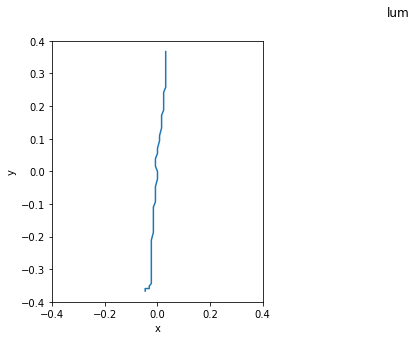

In [12]:
plot_stroke(strokes[1])

In [13]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue
  
  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

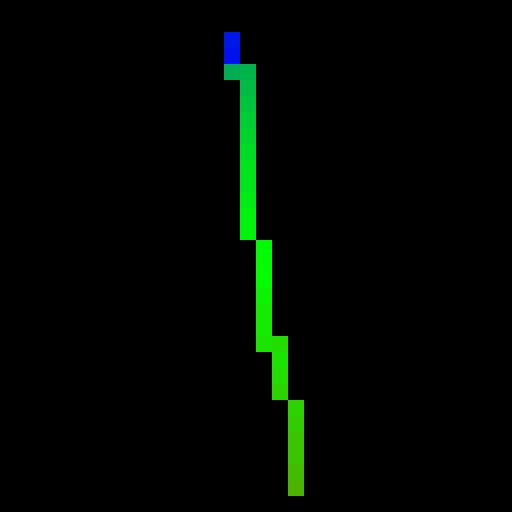

In [14]:
raster = rasterize_stroke(strokes[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

In [15]:
from pathlib import Path
import shutil

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))


In [16]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

shuffled_strokes = strokes
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [17]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

validation_ds = image_dataset_from_directory(
    directory='validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds = image_dataset_from_directory(
    directory='train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 76 files belonging to 4 classes.
Found 6721 files belonging to 4 classes.


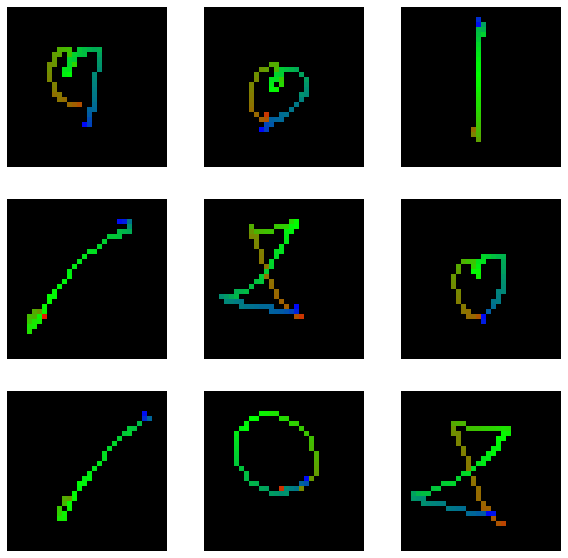

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

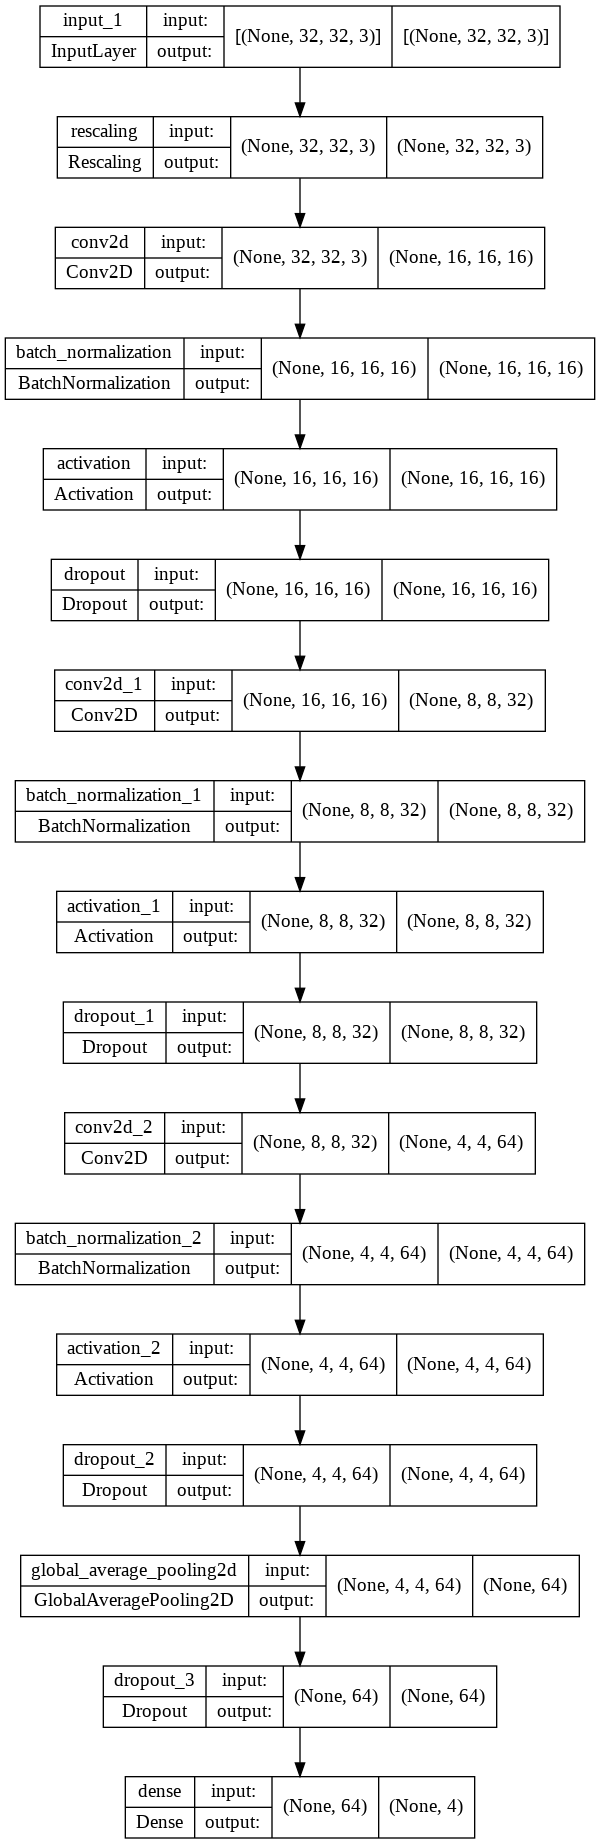

In [20]:
model = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

In [21]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds,
)

Epoch 1/30
211/211 [==============================] - 7s 27ms/step - loss: 0.5270 - accuracy: 0.4581 - val_loss: 0.7451 - val_accuracy: 0.2368
Epoch 2/30
211/211 [==============================] - 6s 26ms/step - loss: 0.3670 - accuracy: 0.7233 - val_loss: 0.6168 - val_accuracy: 0.2895
Epoch 3/30
211/211 [==============================] - 5s 25ms/step - loss: 0.2690 - accuracy: 0.8328 - val_loss: 0.1768 - val_accuracy: 0.9605
Epoch 4/30
211/211 [==============================] - 5s 26ms/step - loss: 0.1982 - accuracy: 0.8933 - val_loss: 0.1242 - val_accuracy: 0.9474
Epoch 5/30
211/211 [==============================] - 6s 26ms/step - loss: 0.1513 - accuracy: 0.9256 - val_loss: 0.0603 - val_accuracy: 0.9868
Epoch 6/30
211/211 [==============================] - 6s 30ms/step - loss: 0.1339 - accuracy: 0.9313 - val_loss: 0.0591 - val_accuracy: 1.0000
Epoch 7/30
211/211 [==============================] - 5s 25ms/step - loss: 0.1142 - accuracy: 0.9426 - val_loss: 0.0467 - val_accuracy: 1.0000

In [23]:
def predict_image(model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  predictions = model.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)
  
index, score = predict_image(model, "test/o/2.png")

print(index, score)


3 0.99999976


In [25]:
model.save(SAVED_MODEL_FILENAME)

INFO:tensorflow:Assets written to: saved_model/assets


In [26]:
!curl -L https://storage.googleapis.com/download.tensorflow.org/models/tflite/micro/magic_wand_saved_model_2021_01_02.tgz -o saved_model.tgz
!tar -xzf saved_model.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  304k  100  304k    0     0  2718k      0 --:--:-- --:--:-- --:--:-- 2718k


In [27]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

def representative_dataset():
  for filename in glob.glob("test/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

32048

In [28]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])
  
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)
  
  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [31]:
predict_tflite(model_no_quant_tflite, "test/hg/5.png")

(9, 0.950142)

In [52]:
predict_tflite(model_tflite, "test/hr/2_a5.png")

(4, 0.91796875)

In [54]:
import os
import pandas as pd

def get_dir_size(dir):
  size = 0
  for f in os.scandir(dir):
    if f.is_file():
      size += f.stat().st_size
    elif f.is_dir():
      size += get_dir_size(f.path)
  return size

# Calculate size
size_tf = get_dir_size(SAVED_MODEL_FILENAME)
size_no_quant_tflite = os.path.getsize(FLOAT_TFL_MODEL_FILENAME)
size_tflite = os.path.getsize(QUANTIZED_TFL_MODEL_FILENAME)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")


,Size,
Model,,
TensorFlow,698094 bytes,
TensorFlow Lite,101276 bytes,(reduced by 596818 bytes)
TensorFlow Lite Quantized,32048 bytes,(reduced by 69228 bytes)


In [55]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.com/ubuntu 

In [56]:
# Print the C source file
!tail {TFL_CC_MODEL_FILENAME}

  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x5f, 0x69, 0x6e, 0x70, 0x75,
  0x74, 0x5f, 0x32, 0x3a, 0x30, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xff, 0xff, 0xff, 0xff, 0x20, 0x00, 0x00, 0x00, 0x20, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x00, 0x00, 0x80, 0x3f,
  0x01, 0x00, 0x00, 0x00, 0x80, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff, 0xff,
  0x04, 0x00, 0x04, 0x00, 0x04, 0x00, 0x00, 0x00
};
unsigned int g_magic_wand_model_data_len = 32048;


In [57]:
print(TFL_CC_MODEL_FILENAME)

techno_wand_model_data.cc
